In [1]:
import pandas as pd
import numpy as np
import random
from string import printable
import string
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer

In [2]:
#get the labelled/ground-truth dataset
labelled=pd.read_csv("D:/Desktop/misogynylabelled.csv", encoding='ISO 8859-1')

In [1]:
#Cleaning the data

In [3]:
#removing handle names
labelled["text"] = labelled['text'].replace('@[^\s]+', '', regex=True)

In [4]:
#remove non-ASCII characters
st = set(printable)
labelled["text_clean"] = labelled["text"].apply(lambda x: ''.join([" " if  i not in  st else i for i in x]))

In [6]:
#removing urls
labelled['text_clean'] = labelled['text_clean'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [7]:
#converting to no caps
labelled["text_clean"] = labelled["text_clean"].str.lower()

In [8]:
#removing non-alphabet characters except space - replacing non-alphabet with a space so that words don't get combined
labelled["text_clean"] = labelled['text_clean'].replace('[^a-zA-Z1-9 ]', ' ', regex=True)

In [9]:
#getting ready to remove stop words
stop_words=stopwords.words('english')
extra_words=["amp"]
stop_words.extend(extra_words)
#removing stopwords
labelled["text_clean"] = labelled["text_clean"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [10]:
labelled = labelled[labelled.text_clean != ''].copy()

In [ ]:
# lemmatize after tokenizing

In [12]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [13]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]

In [14]:
labelled['text_lemmatized'] = labelled.text_clean.apply(lemmatize_text)

In [17]:
labelled=labelled.dropna()

In [19]:
#Split data into training and testing sets

from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(labelled["text_lemmatized"], labelled["misogyny"], test_size=0.30)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer(lowercase=False)
Tfidf_vect.fit(labelled['text_lemmatized'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [21]:
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [22]:
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score, precision_score,balanced_accuracy_score

In [23]:
SVM = svm.SVC(C=1000, kernel ='sigmoid', gamma=0.001)
SVM.fit(Train_X_Tfidf,Train_Y)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
trainpred = SVM.predict(Train_X_Tfidf)
testpred = SVM.predict(Test_X_Tfidf)

In [29]:
# Evaluating the model
print("SVM Accuracy Score -> ",accuracy_score(testpred, Test_Y))
print("SVM Precision Score -> ",precision_score(testpred, Test_Y))
print("SVM Recall Score -> ",recall_score(testpred, Test_Y))
print("SVM BAR Score -> ",balanced_accuracy_score(testpred, Test_Y))

SVM Accuracy Score ->  0.9954624543686671
SVM Precision Score ->  0.8527508090614887
SVM Recall Score ->  0.9261862917398945
SVM BAR Score ->  0.9615100966736492


# Labelling the large dataset

In [34]:
southasia=pd.read_csv("D:/southasia_tweets.csv", dtype='unicode')

In [37]:
#removing handle names
southasia["text"] = southasia['text'].replace('@[^\s]+', '', regex=True)

In [38]:
southasia["text"]=southasia["text"].astype(str)

In [39]:
#remove non-ASCII characters
southasia["text"] = southasia["text"].apply(lambda x: ''.join([" " if  i not in  st else i for i in x]))

In [40]:
#removing urls
southasia['text'] = southasia['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [42]:
#removing non-alphabet characters except space - replacing non-alphabet with a space so that words don't get combined
southasia["text"] = southasia['text'].replace('[^a-zA-Z1-9 ]', ' ', regex=True)

In [43]:
#removing stopwords
southasia["text"] = southasia["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [45]:
southasia['text_lemmatized'] = southasia.text.apply(lemmatize_text)

In [46]:
southasia['text_lemmatized'] = southasia['text_lemmatized'].astype(str)

In [47]:
#TFIDF - transforming the text
X = Tfidf_vect.transform(southasia["text_lemmatized"])

In [48]:
#Using the SVM model to predict labels for each tweet
predictedlabels=SVM.predict(X)

In [49]:
#storing it as a pandas column
southasia["misogyny"] = predictedlabels

In [54]:
southasia['Date'] = pd.to_datetime(southasia['created_at'])

In [56]:
#one pandas dataframe with count of total tweets and misogynystic tweets per day, by country
df=pd.DataFrame()
df=southasia.groupby(['Date', 'country']).agg(misogyny=('misogyny', 'sum'), total=('misogyny', 'count'),)

In [57]:
df=df.sort_values(by='Date')

In [59]:
df.reset_index(level=0, inplace=True)

In [65]:
df['percentmisogyny']=(df['misogyny']/df['total'])*100000

In [12]:
final_merged=df.groupby(['Date']).agg(misogyny=('misogyny', 'sum'), total=('total', 'sum'),)

In [13]:
final_merged.reset_index(inplace=True)

In [14]:
final_merged["percent"]=(final_merged["misogyny"]/final_merged["total"])*100000
final_merged=final_merged.dropna()

In [18]:
final_merged=final_merged.sort_values(by='Date')

In [19]:
final_merged["Date"]=final_merged['Date'].dt.date

In [35]:
PK=df[df["country"]=="PK"]
IN=df[df["country"]=="IN"]
NP=df[df["country"]=="NP"]
LK=df[df["country"]=="LK"]
BD=df[df["country"]=="BD"]

In [36]:
from matplotlib import pyplot as plt

In [37]:
plt.rcParams["figure.figsize"] = [20, 5]

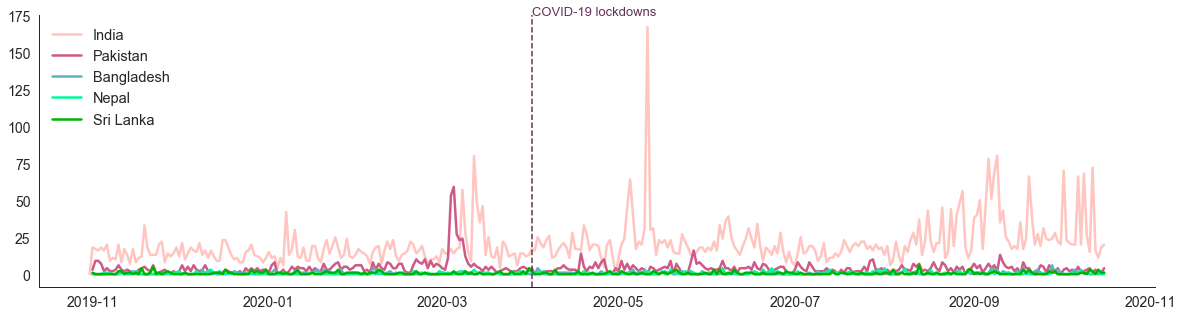

In [43]:
#Figure 1 - plotting daily number of misogynystic posts
plt.plot(IN['Date'], IN['misogyny'].values, color="#ffc5c0", linewidth=2.5, label="India")
plt.plot(PK['Date'], PK['misogyny'].values, color="#cd5a87", linewidth=2.5, label="Pakistan")
plt.plot(BD['Date'], BD['misogyny'].values, color="#60b1c4", linewidth=2.5, label="Bangladesh")
plt.plot(NP['Date'], NP['misogyny'].values, color="mediumspringgreen", linewidth=2.5, label="Nepal")
plt.plot(LK['Date'], LK['misogyny'].values, color="#00b300", linewidth=2.5, label="Sri Lanka")

plt.xticks(horizontalalignment="center", fontname="Arial", fontsize=14)
plt.yticks(horizontalalignment="right", fontname="Arial", fontsize=14)
ax = plt.gca()
ax.legend(frameon=False, loc='upper left', prop={'family': 'Arial', 'size':14.5})
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.axvline(covid, color='#623357', linestyle='--', lw=1.5)
plt.text(covid,175, 'COVID-19 lockdowns', size=13, color='#623357')
#plt.savefig('C:/Desktop/numbermisogynyposts.png', transparent=True)